- read tifs
- aggregate into tiles
- write csv or pickle

## installation
### dependencies
try apt-get install python-rasterio python-geopandas. On Ubuntu 16.04 this brings in rasterio-0.31

- install/upgrade via pip:
    - pip install --upgrade enum34 requests rasterio geopandas
 
If pip install rasterio fails:
rasterio/_base.c:287:22: fatal error: cpl_conv.h: No such file or directory
just apt-get install libgdal-dev



In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
#get_ipython().magic(u'load_ext autoreload')
#get_ipython().magic(u'autoreload 2')

import os
import sys
os.chdir("/home/albrecht/csiro/src/lpr")
sys.path.append(os.getcwd())
#sys.path.append("/mnt/hgfs/albrecht/lib/python/env/jupyter/lib/python2.7/site-packages") # FIXME: why is virtualenv path not picked up automatically?

import geopandas
import pandas as pd
import numpy as np
import matplotlib
#matplotlib.use("AGG") # prevent X11
import matplotlib.pyplot as plt
import scipy.stats.mstats
from pdb import pm
import numpy.testing as npt
from sklearn import svm
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import string
from tictoc import Tic
import collections
import pub
from textwrap import dedent
from sklearn.metrics import confusion_matrix, precision_score

from common import FeatureCallback, FeatureHistogram, Aggregator, \
                   figsize, memory_usage_MB, \
                   get_equal_freq_bins, interquatrile_range, BlockInfo, \
                   MapPlotter, map_class_ID_to_colour, \
                   load_src_and_band, map_step_to_scatter_size

from importruntime import importRuntime
import session
import logging as log
import argparse
from hashlib import md5
from table import Table


# Plot style for Comp & Geosci
pub.SetPlotRC_CompGeosci()

/usr/lib/python3/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
if 0:
    parser = argparse.ArgumentParser(description="")
    #parser.add_argument("-", action="store", type=float, default=0, help="")
    parser.add_argument("-c", '--use-cache-only', action="store_true", help="Process only if cache exists")
    parser.add_argument("-a", '--aggregate-only', action="store_true", help="Aggregate only, skip prediction.")
    parser.add_argument("-v", "--verbose", dest="verbose_count", action="count",
                        default=0, help="increase verbosity")
    parser.add_argument("-q", "--quiet", dest="quiet_count", action="count",
                        default=0, help="decrease verbosity")
    parser.add_argument('session', metavar='file', type=str, nargs=1,
                        help='the session file')
    args = parser.parse_args() #["-v", "session_c0_f42_t1"]) # remove for non-interactive use!
    log.basicConfig(level=(max(3 - args.verbose_count + args.quiet_count, 0) * 10), # defaults to 30, i.e. WARN
                        format='%(levelname)s:%(message)s')

In [5]:
os.chdir("/home/tom/csiro/src/lpr/projects/AFO")
class Args():
    pass
args = Args
# read session file
args.session = "AFO_quick"
log.info("running on Python %s", sys.version_info)
log.info("Reading session %s", args.session)
session.read_from_file(args.session)
session.NAME = args.session
session.OUTDIR = os.path.join("png", session.NAME, "")
session.AGGREGRATE_ONLY = False
session.USE_CACHE_ONLY = True

log.info(session.summary())
pub.mkdirs(session.OUTDIR)


In [6]:
stats_fname = "stats_agg" if session.AGGREGRATE_ONLY else "stats"
stats_fname = session.OUTDIR + stats_fname + '.csv'

stats = Table(stats_fname)


In [7]:
session.PATH_TO_LANDFORMS_SHP

'/home/tom/csiro/src/lpr/projects/AFO/training/Landforms_2018_04_26.shp'

In [8]:

shapefile = geopandas.read_file("/home/tom/tmp/landscape/landforms/Landforms_2018_04_26.shp")
geoms = shapefile.geometry.values # list of shapely geometries


9


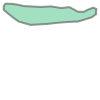

In [9]:
print (len(geoms))
geoms[7]

In [10]:
shapefile = geopandas.read_file(session.PATH_TO_LANDFORMS_SHP)
geoms_all = shapefile.geometry.values # list of shapely geometries

# re-order land classes
if session.FILTER_GEOMS is not None:
    geoms = [geoms_all[i] for i in session.FILTER_GEOMS]

# In[ ]:

relief_dict = {6: (46, 56, 66, 76),
               5: (35, 45, 55, 65, 75, 34, 44, 54, 64, 74),
               3: (33, 43, 53, 63),
               2: (22, 32, 42, 52),
               1: (11, 21, 31, 41),
               4: (51, 61, 71, 62, 72, 73)}

def relief_histogram(data):
    """map relief. Accept flattened data, return a vector"""

    # map data to relief_class
    keys = [key if item in value else 0 for item in data for key, value in relief_dict.items()]

    # compute histogram of relief class
    bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
    return np.histogram(keys, bins=bins)[0]

def test_relief_histogram():
    npt.assert_array_equal(relief_histogram([11]), [1, 0, 0, 0, 0, 0])
    npt.assert_array_equal(relief_histogram([22]), [0, 1, 0, 0, 0, 0])
    npt.assert_array_equal(relief_histogram([33]), [0, 0, 1, 0, 0, 0])
    npt.assert_array_equal(relief_histogram([51]), [0, 0, 0, 1, 0, 0])
    npt.assert_array_equal(relief_histogram([35]), [0, 0, 0, 0, 1, 0])
    npt.assert_array_equal(relief_histogram([46]), [0, 0, 0, 0, 0, 1])

test_relief_histogram()



## Assemble featureX dict

In [11]:
fdict = {}

def add_to_dict(ftif):
    ftif.add_to_dict(fdict)

def path_to(the_tif):
    return os.path.join(session.PATH_TO_TIFS, the_tif)

if 1 and not session.QUICK:
    the_tif =  path_to("elev.tif")
    add_to_dict(FeatureCallback(the_tif, ["eskewness"], callback=scipy.stats.mstats.skew))
    add_to_dict(FeatureCallback(the_tif, ["ekurtosis"], callback=scipy.stats.mstats.kurtosis))
    add_to_dict(FeatureCallback(the_tif, ["eiqr"], callback=interquatrile_range))

bins = np.arange(11)
add_to_dict(FeatureHistogram( path_to("mrvbf.tif"), bins=bins, feature_prefix='vbf'))

add_to_dict(FeatureHistogram( path_to("mrrtf.tif"), bins=bins, feature_prefix='rtf'))


# equal freq binning
if 1 and not session.QUICK:
    n_bins = 5
    src, data, valid_data = load_src_and_band(the_tif)
    bins = get_equal_freq_bins(valid_data, n_bins)
    add_to_dict(FeatureHistogram(path_to("profcurv.tif"), bins=bins, feature_prefix='profcurv', feature_postfixes=np.arange(n_bins)+1))

##the_tif = "plancurv.tif"
##n_bins = 5
##src, data, valid_data = load_src_and_band(the_tif)
##bins = get_equal_freq_bins(valid_data, n_bins)
##add_to_dict(FeatureHistogram(the_tif, bins=bins, feature_prefix='plancurv', feature_postfix=np.arange(n_bins)+1)

 # topo wetness index
add_to_dict(FeatureCallback(path_to("twi.tif"), ["tmean"], callback=np.mean))

if 1 and not session.QUICK:
    the_tif = path_to("slope.tif")
    add_to_dict(FeatureCallback(the_tif, ["sskewness"], callback=scipy.stats.mstats.skew))
    add_to_dict(FeatureCallback(the_tif, ["skurtosis"], callback=scipy.stats.mstats.kurtosis))
    add_to_dict(FeatureCallback(the_tif, ["siqr"], callback=interquatrile_range))

if 1 and not session.QUICK:
    the_tif = path_to("wei.tif") # wind exposure index
    add_to_dict(FeatureCallback(the_tif, ["wskewness"], callback=scipy.stats.mstats.skew))
    add_to_dict(FeatureCallback(the_tif, ["wkurtosis"], callback=scipy.stats.mstats.kurtosis))
    add_to_dict(FeatureCallback(the_tif, ["wiqr"], callback=interquatrile_range))
    add_to_dict(FeatureCallback(the_tif, ["wmean"], callback=np.mean))

# slopeRCL
if 1 and not session.QUICK:
    # "slopeLE","slopeVG","slopeGE","slopeMO","slopeST","slopeVS",
    slope_bins  = [16, 26, 36, 46, 56, 66, 76]
    slope_names = ["LE", "VG", "GE", "MO", "ST", "VS", "CL"]
    bins=slope_bins
    #{"LE": 16, "VG": 26, "GE": 36, "MO": 46, "ST": 56, "VS": 66, "CL": 76}
    add_to_dict(FeatureHistogram(path_to("sloperelcl.tif"), bins=slope_bins, feature_prefix='slope', feature_postfixes=slope_names[:-1]))

#"reliefP","reliefR","reliefL","reliefH","reliefM",
# relief
if 0 and not session.QUICK:
    add_to_dict(FeatureCallback(path_to("sloperelcl.tif"), feature_names=['relP', 'relR', 'relL', 'relH', 'relM', 'relB'], callback=relief_histogram))


## Pick which features to train on. Either use all features...
ftifs = [val for val in fdict.values()]

## ... or cherry-pick
# TODO: monday.
if session.QUICK:
    ftifs = [ fdict['vbf'] ]
    #ftifs = [ fdict["sskewness"], fdict["skurtosis"] ]

#ftifs = [ fdict['wiqr'], fdict['siqr'], fdict['eiqr'] ]



In [12]:
def simple_mean_scorer(y_true, y_pred):
    """compute accuracy for each class, return average"""
    accuracy = []
    #log.info("%i unique classes", len(np.unique(y_true)))
    #log.info("len(y_pred) = %i len(y_true) = %i", len(y_true), len(y_pred))
    for class_ID in range(int(y_true.min()), int(y_true.max()+1)):
        mask = y_true == class_ID
        this_class_correct = (y_pred[mask] == y_true[mask]).sum()
        this_class_accuracy = this_class_correct / float(mask.sum())
        accuracy.append(this_class_accuracy)
        #log.info("c%i  %5i/%5i  %5.3f", class_ID, this_class_correct, mask.sum(), this_class_accuracy)
    accuracy = np.array(accuracy).mean()
    #print_confusion_matrix(y_true, y_pred, "CM")
    #log.info("acc %5.3f", accuracy)
    return accuracy

def print_confusion_matrix(y_true, y_pred, message=None):
    if message is not None:
        log.info(message)
    cm = confusion_matrix(y_true, y_pred)
    log.info('\n' + str(cm))
    cm_normed = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    np.set_printoptions(precision=3, suppress=True)
    log.info('\n' + str(cm_normed))
    return cm, cm_normed


#####################################################################################
## for interactive debugging in spyder, set interactive = 1 and uncomment 'if' below.
interactive = 1
# In[ ]:
if interactive:
    size = 51
    small_size = 25
    step = 50
    size = session.SIZES[0]
    step = session.STEPS[0]

## Aggregate training data

In [13]:
    block_info = BlockInfo(size_x=size, size_y=size, step_x=step, step_y=step,
                           small_size_x=small_size, small_size_y=small_size)
    #np.set_printoptions(precision=3, suppress=True)

    aggregator = Aggregator(block_info, ftifs, geoms,
                            circular_mask=session.CIRCULAR_MASK,
                            use_small_blocks=session.USE_SMALL_BLOCKS)

    stats["n_features"] = aggregator.n_features
    size_metres = np.array(aggregator.block_size_metres())

    log.info("size, step, small_size %i %i %i", size, step, small_size)
    log.info("average block size %5.2f km", size_metres.mean() / 1000.)

    stats["size"] = size
    stats["step"] = step
    stats["small_size"] = small_size
    stats["avg_block_km"] = (size_metres.mean() / 1000.)

    if not session.AGGREGRATE_ONLY:
        log.info("aggregate training ...")

        training_data = aggregator.aggregate(path_to_cache=os.path.join(session.PATH_TO_CACHE, "train"),
                                             csv_filename="quickt.csv")#, ax=None)
        log.info("%i features: %s ", aggregator.n_features, str(aggregator.hdr[:-3]))
        log.info("training matrix shape %s", str(training_data.shape))
        log.info("done.")



>>> stats.setitem called
>>> d len 0
>>> n_features = 10
>>> stats.setitem called
>>> d len 1
>>> size = 51
>>> stats.setitem called
>>> d len 2
>>> step = 25
>>> stats.setitem called
>>> d len 3
>>> small_size = 25
>>> stats.setitem called
>>> d len 4
>>> avg_block_km = 39.491228815992116


/home/tom/csiro/src/lpr/src/common.py:438: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  crop=True, crop_to_shape=False) #, invert=False)


## Aggregate entire map

In [14]:
    ###############################################################################
    ## Aggregate entire map, by passing geoms=None
    ###############################################################################
    log.info("aggregate entire map...")
    timer = Tic()
    aggregator_map = Aggregator(block_info, ftifs, geoms=None,
                                circular_mask=session.CIRCULAR_MASK,
                                use_small_blocks=session.USE_SMALL_BLOCKS)
    entire_data = aggregator_map.aggregate(ax=None, csv_filename="quick.csv",
                                           path_to_cache=session.PATH_TO_CACHE)
    stats["t_aggregate_map"] = timer.toc()
    stats['mem_after_agg_MB'] = memory_usage_MB()

    log.info("feature matrix shape " + str(entire_data.shape))
    log.info("Done.")

# In[ ]:
    ## build vector of (training) class labels
    from shapely.geometry import Point
    def get_class_for_lonlat(feature_matrix, geoms):
        enumerated_geoms = list(enumerate(geoms))
        def _class(p):
            for i, the_geom in enumerated_geoms:
                if the_geom.contains(p):
                    return i
            return -1
        
        return [_class(Point(lonlat)) for lonlat in feature_matrix[:,-2:]]
    y_true = np.array(get_class_for_lonlat(entire_data, geoms))

# In[ ]:
    if session.AGGREGRATE_ONLY:
        stats.newline()


>>> stats.setitem called
>>> d len 5
>>> t_aggregate_map = 0.053160905838012695
>>> stats.setitem called
>>> d len 6
>>> mem_after_agg_MB = 208.5859375


In [15]:
    # a mask of nodata location. Used later to prevent plotting of classification
    # where source data is, e.g. ocean. Unfortunately, this approach won't work
    # because we filter feature matrix.
    # Options: (1) filter mask as well.
    #          (2) at plotting time, transform lonlat to px and test with mrVBF

    #mask = aggregator_map.invalid_mask()


## Train

In [16]:
# In[ ]:
    ###############################################################################
    ## Train. Follow sklearn terminology:
    ## X is matrix of training data, y is vector of labels
    ###############################################################################
    X_train = training_data[:,:-3]
    y_train = training_data[:,-3]

    assert(np.isfinite(X_train).all())
    assert(np.isfinite(y_train).all())


    # dict which maps clf name : (method, is_unsupervised)
    CLFs = collections.OrderedDict([
#            ("DT", (tree.DecisionTreeClassifier(random_state=42), False)),
#            ("DT1", (tree.DecisionTreeClassifier(random_state=42), False))
            #("lSVc1e1", (svm.LinearSVC(class_weight="balanced", C=1e1), False)),
            #("lSVc1e2", (svm.LinearSVC(class_weight="balanced", C=1e2), False)),
            #("lSVc1e3", (svm.LinearSVC(class_weight="balanced", C=1e3), False)),
            #("SV", (svm.SVC(class_weight="balanced", gamma=1e-4, C=1e6), False)),
            #("RF1000", (ensemble.RandomForestClassifier(n_estimators = 1000, random_state = 42), False)),
            ("RF100", (ensemble.RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced"), False)),
#            ("DT", (tree.DecisionTreeClassifier(random_state=42), False))
          ])

    #CLFs = {"SV": (svm.SVC(class_weight="balanced"), False)}

    #CLFs = collections.OrderedDict([
            #("RF100", (ensemble.RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced"), False))
          #])

    #CLFs = {"RF100" : (ensemble.RandomForestClassifier(n_estimators = 100, random_state = 42), False)}
    #CLFs = {"RF" : (ensemble.RandomForestClassifier(n_estimators = 100, random_state = 42), False)}

    #for n_clusters in range(2, 10):
    #    clf = KMeans(n_clusters=n_clusters, random_state=0) #.fit(X)
    #    clf_name = "km%i" % n_clusters
# In[ ]:

    for clf_name, (clf, is_unsupervised) in CLFs.items():

        stats["clf_name"] = clf_name
        stats["is_unsupervised"] = is_unsupervised
    #clf = tree.DecisionTreeClassifier()
    #clf_name = "DT"
# In[ ]:
        #clf = svm.SVC() #(kernel="poly", degree=3)
        #clf_name = "SVC"

        log.info("training %s ...", clf_name)

        ###############################################################################
        ## k-fold cross-validation.
        ##
        ## k can't be greater than smallest sample size, so count samples for each class
        ###############################################################################
        k = 5
        hist, _ = np.histogram(y_train, bins=np.arange(0, len(geoms)))
        k = min(hist.min(), k)
        assert(hist.sum() == len(y_train))

        
        if session.CROSS_VALIDATE and k >= 2:
            # either use sklearn's cross-validate...
            if 0:
                log.info("%i-fold CV", k)
                averaging = ['micro', 'macro', 'weighted']
                scoring = [item+"_"+the_avg for item in ['precision', 'recall', 'f1'] for the_avg in averaging]
                scoring += ['accuracy']
                scores = cross_validate(clf, X_train, y_train, scoring=scoring,
                                        cv=k, return_train_score=False)
                accuracy = scores['test_accuracy']
    
                np.set_printoptions(precision=3)
                param_str = "size: %i  step: %i %s %i feat Acc: %0.3f (+/- %0.2f)\n%s"  \
                    % (size, step, clf_name, aggregator_map.n_features,
                       accuracy.mean(), accuracy.std() * 2,
                       string.join(["%3i" % int(item) for item in accuracy*1000]))
    
                for the_avg in averaging:
                    for item in ['precision', 'recall', 'f1']:
                        stats["%s_%s_mean" % (item, the_avg)] = scores['test_%s_%s' % (item, the_avg)].mean()
                        stats["%s_%s_std" % (item, the_avg)] = scores['test_%s_%s' % (item, the_avg)].std()
                stats["accuracy_mean"] = accuracy.mean()
                stats["accuracy_std"] = accuracy.std()

            else: # ... or use home-brew scorer
                log.info("Using home-brew scorer k=%i", k)
                from sklearn.metrics import make_scorer
    
                scorer = make_scorer(simple_mean_scorer, greater_is_better=True)
                scores = cross_validate(clf, X_train, y_train, scoring=scorer,
                                        cv=k)#, return_train_score=False)
                accuracy = scores['test_score']
                stats["accuracy_mean"] = accuracy.mean()
                stats["accuracy_std"] = accuracy.std()
    
                param_str = "size: %i  step: %i %s %i feat Acc: %0.3f (+/- %0.2f)\n%s"  \
                    % (size, step, clf_name, aggregator_map.n_features,
                       accuracy.mean(), accuracy.std() * 2,
                       " ".join(["%3i" % int(item) for item in accuracy*1000]))
    

        #if 0:
        else:
            param_str = "size: %i  step: %i %s %i feat " \
            % (size, step, clf_name, aggregator_map.n_features)
            param_str +=  "no cross-valid possible" if session.CROSS_VALIDATE else "cross-valid disabled"

            stats["k-fold CV"] = -1
            stats["accuracy_mean"] = -1
            stats["accuracy_std"] = -1
# In[ ]:

        log.info(param_str)

        timer = Tic()
        if is_unsupervised:
            clf.fit(X_train)
        else:
            clf.fit(X_train, y_train)
        stats["t_train"] = timer.toc()

        log.info("done.")


>>> stats.setitem called
>>> d len 7
>>> clf_name = RF100
>>> stats.setitem called
>>> d len 8
>>> is_unsupervised = False
>>> stats.setitem called
>>> d len 9
>>> k-fold CV = -1
>>> stats.setitem called
>>> d len 10
>>> accuracy_mean = -1
>>> stats.setitem called
>>> d len 11
>>> accuracy_std = -1
>>> stats.setitem called
>>> d len 12
>>> t_train = 2.675912380218506


In [17]:
        # there is a very nice plotting example
        # http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
        ###############################################################################
        ## confusion matrix using entire training set (conceptually flawed!)
        ###############################################################################
        y_pred = clf.predict(X_train)
        _, cm_normed = print_confusion_matrix(y_train, y_pred, 
                                              message="Confusion matrix using entire training set -- use with caution, conceptually flawed!")
        
        # accuracy: average of diagonal of confusion matrix
        stats["accuracy_diag_mean"] = cm_normed.diagonal().mean()
        stats["accuracy_diag_std"] = cm_normed.diagonal().std()
        log.info("accuracy_diag_mean = %g +- %g", stats["accuracy_diag_mean"], stats["accuracy_diag_std"])
        ###############################################################################
        # plot training
        ###############################################################################
        if 0:
            lonlat  = training_data[:,-2:]
            scatter_size = map_step_to_scatter_size[step]
    
            #c_predicted = map_class_ID_to_colour(y_pred)
            fig, ax = plt.subplots(1,1,figsize=figsize)
            map_filename = session.OUTDIR + "AFO_pred%s_size%03i_step%03i.train.png" % (clf_name, size, step)
            mp = MapPlotter(lonlat, scatter_size, geoms, block_info, 
                            map_class_ID_to_colour, ax, aggregator.master_src, 
                            filename=None)
            #mp.plot(y_pred, alpha=0.5*255)
            mp.plot_geoms()
            # parameter string on top of plot
            ax.text(0., 1.05, param_str, transform=ax.transAxes)
    
            plt.savefig(map_filename, dpi=200)
            plt.close()




>>> stats.setitem called
>>> d len 13
>>> accuracy_diag_mean = 0.9936074344982675
>>> stats.setitem called
>>> d len 14
>>> accuracy_diag_std = 0.0102010511983733


In [18]:
        ###############################################################################
        ## Predict entire map, then plot
        ###############################################################################
        X = entire_data[:,:-3]
        lonlat_map = entire_data[:,-2:]

        timer = Tic()
        y_pred = clf.predict(X)
        stats["t_predict_map"] = timer.toc()
       
# In[ ]:
        ## accuracy on entire map
        acc_total = np.zeros(len(geoms))
        acc_correct = np.zeros_like(acc_total)

        mask = y_true > -1
        log.info("Total training samples %i", len(y_true[mask])) 
        CM, CM_normed = print_confusion_matrix(y_true[mask], y_pred[mask], message="CM entire map for %s at %i %i" % (clf_name, size, step))
        #CM = np.zeros((len(geoms), len(geoms))
        for item_true, item_pred in zip(y_true, y_pred):
            if item_true > -1:
                acc_total[item_true] += 1
                #CM[item_true, item_pred] += 1
                if item_true == item_pred:
                    acc_correct[item_true] += 1
        accuracy_entire_diag = acc_correct/acc_total
        log.info("correct/total %s", str(accuracy_entire_diag))
        stats["accuracy_entire_diag_mean"] = accuracy_entire_diag.mean()
        stats["accuracy_entire_diag_std"] = accuracy_entire_diag.std()
        stats["CM"] = CM.flatten()
        stats["CM_normed"] = CM_normed.flatten()




>>> stats.setitem called
>>> d len 15
>>> t_predict_map = 4.230205535888672
>>> stats.setitem called
>>> d len 16
>>> accuracy_entire_diag_mean = 0.6502954232431386
>>> stats.setitem called
>>> d len 17
>>> accuracy_entire_diag_std = 0.21919238514315256
>>> stats.setitem called
>>> d len 18
>>> CM = [ 614   46   22   79    7    2   17    9   77  376    3   25    0    0
   31   27    8    3 2426  303   25   12    6  769   27    8  334 1186
    5    0   21  387    3    2   77   23  287    0   11  406    0    0
    6    3    0 1710    0   89   44   63    9   74   15    0  143  171
    2   13  521  164  224  300   33 8540]
>>> stats.setitem called
>>> d len 19
>>> CM_normed = [0.771 0.058 0.028 0.099 0.009 0.003 0.021 0.011 0.143 0.698 0.006 0.046
 0.    0.    0.058 0.05  0.002 0.001 0.683 0.085 0.007 0.003 0.002 0.216
 0.014 0.004 0.17  0.603 0.003 0.    0.011 0.197 0.004 0.002 0.095 0.028
 0.355 0.    0.014 0.502 0.    0.    0.003 0.002 0.    0.946 0.    0.049
 0.085 0.121 0.017 0.143 0.

# Outlier detection May 2019

# Train

In [12]:
    ###############################################################################
    ## Train. Follow sklearn terminology:
    ## X is matrix of training data, y is vector of labels
    ###############################################################################
    X_train = training_data[:,:-3]
    y_train = training_data[:,-3]
    X = entire_data[:,:-3]
    lonlat_map = entire_data[:,-2:]
    lonlat  = training_data[:,-2:]
    scatter_size = map_step_to_scatter_size[step]

    assert(np.isfinite(X_train).all())
    assert(np.isfinite(y_train).all())

    CLFs = collections.OrderedDict([
            ("OneclassSVM", svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=1e-4)), # very good
            #("IsolationForest", IsolationForest(max_samples=1000, random_state=42, contamination=0.01)),
            #("LocalOutlierFactor", LocalOutlierFactor(n_neighbors=500)
    ])

    for clf_name, clf in CLFs.items():
            
        if clf_name == "LocalOutlierFactor":
            y_pred = clf.fit_predict(X)
        else:
            clf.fit(X_train)
            y_pred = clf.predict(X)

            

/home/tom/csiro/src/lpr/src/common.py:1137: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  self._set_transform(src_image)
/usr/lib/python3/dist-packages/rasterio/__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


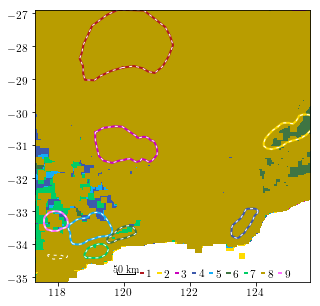

In [89]:
    
        from common import MapPlotter
        #fig, (ax0, ax1) = plt.subplots(1,2, figsize=(30,6)); 
        from common import figsize
        fig, ax0 = plt.subplots(1,1,figsize=figsize)

        #plt.tight_layout()
        scatter_size = 1
        mp = MapPlotter(lonlat_map, scatter_size*1, geoms_all, block_info, map_class_ID_to_colour, ax0, 
                        aggregator.master_src, filename=None)
        #bins, hist, patches = ax1.hist(y_pred, bins=100)
        mask = y_pred > 0 # +1 normal data -1 outlier

        mp.plot_background(path_to("background_mrvbf.tif"), alpha=0.7)
        mp.plot_geoms()
   #     mp.plot_outlier(y_pred)
        mp.plot(y_pred, alpha=1.0)

        map_filename = session.OUTDIR + "AFO_outlier_zoom_%s_size%03i_step%03i.png" % \
                                         (clf_name, size, step)
        #plt.xlim(117.279, 120.5)
        #plt.ylim(-35.146, -32.5)
        
        mp.plot_scale(119.8, -34.9, 0.05, 50)
        ax0.legend(ncol=9, loc="lower left",
                  markerscale=0.02, columnspacing=0.5,
                  handlelength=0.2, handletextpad=0.3, frameon=False,
                  bbox_to_anchor=(0.35, -0.029))

        #plt.savefig(map_filename, dpi=300)
        plt.show()


(1200, -100)

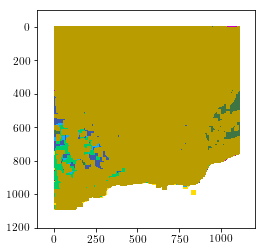

In [94]:
plt.imshow(mp.img)
plt.xlim(-100, 1200)
plt.ylim(1200,-100)
#mp.src_image.transform, mp.src_image.crs


In [95]:
mp.img.shape

(1098, 1111, 4)

In [55]:
Z.shape

(1098, 1111, 4)

In [100]:
import rasterio
Z = mp.img.transpose((2,0,1))
with rasterio.open(
    'new.tif',
    'w',
    driver='GTiff',
    height=Z.shape[1],
    width=Z.shape[2],
    count=4,
    compress="LZW",
    dtype=np.uint16,
    crs='+proj=latlong',
    transform=mp.src_image.transform,
) as dst:
    dst.write(Z.astype(np.uint16), indexes=(1,2,3,4))

#import rasterio 
#from rasterio.enums import ColorInterp

#dst.colorinterp = (
#            ColorInterp.red, ColorInterp.green, ColorInterp.blue, ColorInterp.alpha)



if 0:
    for k in range(3):
        dst.write(Z[:,:,k].astype(np.uint16), indexes=k+1)
        #dst.set_band_description(k, 'RGBA'[k])
#dst.close()
#for k, arr in [(1, b), (2, g), (3, r)]:
#        dst.write(arr, indexes=k, window=write_window)

In [86]:
dst.write_band?

In [71]:
Z.transpose((2,0,1)).shape

(4, 1098, 1111)

[]

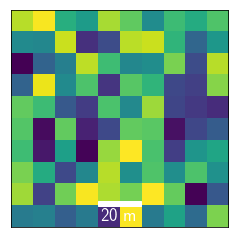

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=18)
fig, ax = plt.subplots()
ax.imshow(np.random.random((10,10)),extent=[0,100,0,100]) 

#Extent defines the images max and min of the horizontal and vertical values.

scalebar = AnchoredSizeBar(ax.transData,
                           20, '20 m', 'lower center', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=2,
                           fontproperties=fontprops)

ax.add_artist(scalebar)

#The four first arguments to AnchoredSizeBar are the transformation object of the coordinate system, scalebar length, label and location. Further optional arguments changes the layout. These are explained well in the docstring.

ax.set_yticks([])
ax.set_xticks([])

In [38]:
plt.text?

The canonical way to convert from row, col to x, y is using the multiplication operator. No need for the translation step or extra functions: (0.5, 0.5) * affine

In [ ]:
# transform lat/lon to px location, using inverse transform
#lonlat_map[0] * 
from affine import Affine
T1 = Affine.from_gdal(*mp.transform) * Affine.translation(0.5, 0.5)


In [ ]:
# inverse transform lon, lat to px. Subtract 0.5 that was added during forward transform
mpx = ((np.array((lonlat_map[:,0], lonlat_map[:,1]) * ~T1) - 0) / 1 ).transpose()

#mpx.shape, mpx[:,0].min(), mpx[:,0].max(), mpx[:,1].min(), mpx[:,1].max()
i0 = mpx[:,1].min() 
i1 = mpx[:,1].max()
j0 = mpx[:,0].min()
j1 = mpx[:,0].max()

#img = np.zeros((i1-i0, j1-j0))
img = np.zeros((mp.src_image.shape[0] // 1, mp.src_image.shape[1] // 1, 4),
                       dtype=np.uint8)

#img = np.zeros((mp.src_image.shape[0] // 25, mp.src_image.shape[1] // 25, 4),
#               dtype=np.uint8)

step = 25
half_bs = step / 2.
# TODO: vectorise?
for (x, y) in mpx:
    img[int(y-half_bs):int(y+half_bs+1), int(x-half_bs):int(x+half_bs+2), 0] = 255
    img[int(y-half_bs):int(y+half_bs+1), int(x-half_bs):int(x+half_bs+2), 3] = 255

    
plt.imshow(img, vmin=0, vmax=255)
plt.imsave("a.png", img/255.)

In [22]:
mpx = ((np.array((lonlat_map[:,0], lonlat_map[:,1]) * ~T1) - 0) / 1 )

In [23]:
mpx

array([[  75.5,  100.5,  125.5, ...,  775.5,  800.5,  825.5],
       [  75.5,   75.5,   75.5, ..., 9800.5, 9800.5, 9800.5]])

In [17]:
for (x, y) in mpx:
    print (x, y)
    break

76 76


In [71]:
T1 = Affine.from_gdal(*mp.transform) * Affine.translation(0.5, 0.5)

#rc2xy = lambda r, c: (c, r) * T1
#print(rc2xy(0, 0))

if 0:
    RC = np.zeros((len(irange), len(jrange), 2))
    # FIXME: list comprehension
    for i, i0 in enumerate(irange):
        for j, j0 in enumerate(jrange):
            # i,j are top-left corners, but we want lat/lon for centre.
            r = i0 + self.block_info.size_y / 2.
            c = j0 + self.block_info.size_x / 2.
            RC[i,j] = (r, c)

# FIXME: this works, but I'm not entirely clear about row/col order here.
print ((117,-31) * ~T1)
((-348.5, 4919.5) * T1)

(-348.5, 4919.500000000004)


(117.0, -31.0)

In [101]:
m = 5
bs = 5
m - bs // 2, m + bs//2 + 1

(3, 8)

In [139]:
np.round(mpx[mask]/25)

array([[  3.,   3.],
       [  4.,   3.],
       [  5.,   3.],
       ...,
       [ 30., 392.],
       [ 31., 392.],
       [ 32., 392.]])

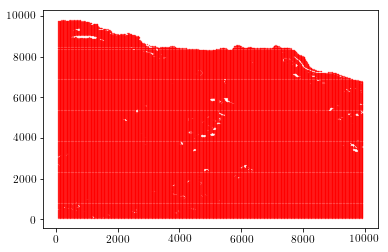

In [86]:
plt.plot(mpx[:,0][mask], mpx[:,1][mask], 'r.', ms=0.5)

In [84]:
mask.sum(), mask.shape

(131498, (132863,))

### do a single train/test split, confusion matrix

### confusion matrix using entire training set (conceptually flawed)

## plot training

## predict entire map and plot

## DONE

## novelty detection

In [ ]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)

In [ ]:
oneclassX = clf.predict(X)


In [ ]:
plt.hist(oneclassX, bins=100)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
mp = MapPlotter(lonlat_map, scatter_size*1.35, geoms, map_class_ID_to_colour, ax)
mp.load_background_tif("background_mrvbf.tif")
mp.plot_background()
mp.plot_geoms()
mask = oneclassX > 0
ax.scatter(lonlat_map[mask,0], lonlat_map[mask,1], 
           #c=map_class_ID_to_colour(class_ID),
           s=scatter_size, marker='s', edgecolors='face', alpha=0.5)


In [ ]:
print X.shape
print clf.predict_proba(X).shape
print clf.predict_proba??

In [ ]:
print clf.predict_proba

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
proba = clf.predict_proba(X)

for class_ID, geom in enumerate(geoms):
    pp = proba[:,class_ID]

    thresholds = [0.5, 0.9]
    #thresholds = [0.3, 0.6, 0.9]
    #thresholds = [0.25, 0.5, 0.75, 0.9]
    #thresholds = np.linspace(0.1, 0.9, 9)
    for threshold in thresholds:
        mask = pp > threshold
        ax.scatter(lonlat_map[mask,0], lonlat_map[mask,1], scatter_size*1.3065, 
                   marker='s', alpha=0.5, c=map_class_ID_to_colour(class_ID))



In [ ]:
np.linspace(0.1, 0.9, 9)

In [ ]:
tot = 0
thresh = 0.5
for i, mask in enumerate(mask_list):
    this_class_distance = distance[:,i]
    print mask.shape, 
    print mask.sum(),
    print (this_class_distance > thresh).sum()
    tot += mask.sum()
print tot

In [ ]:
plt.hist(predicted, bins=np.arange(10)-0.5)

In [ ]:
# distance histogram per class. What is i?
distance.shape
fig, axes = plt.subplots(1,3, figsize=(15,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.hist(distance[:,i], bins=100)
    

In [ ]:
class MapPlotter2(object):
    def __init__(self, lonlat_map, scatter_s, geoms, colour_mapper_callback, ax):
        self.lonlat_map = lonlat_map
        self.scatter_s = scatter_s
        self.colour_mapper_callback = colour_mapper_callback
        self.geoms = geoms
        self.band = None
        self.ax = ax
        self.src = None
        logging.warn("FIXME: mask where BG image is blank")
        
    def load_background_tif(self, the_tif):
        self.src, band, _ = load_src_and_band(the_tif, band_ID=1)
        band[band==self.src.nodata] = 12
        self.band = band
        self.extent = rasterio.plot.plotting_extent(self.src)
        
    def plot_block(self, size, transform=None):
        if transform is None:
            if self.src is None:
                raise ValueError("Can't plot block. Either provide transform, "\
                                 "or call load_background_tif() beforehand")
            transform = self.src.affine
        T1 = transform * Affine.translation(0.5, 0.5)
        RC = np.array([[0,0], [0,size], [size,size], [size,0], [0,0]])
        RC += 10
#            C, R = 
        X, Y = ((RC[:,1], RC[:,0]) * T1)
        self.ax.plot(X, Y, 'y-', lw=3)

    def plot_background(self):
        if self.band is not None:
            self.ax.imshow(self.band, cmap=plt.cm.gray, extent=self.extent) # plot

    def plot_geoms(self):
        
        for i, the_class in enumerate(self.geoms):
            #plot_class(the_class, ax1, color='k')
            x, y = the_class.exterior.xy
            self.ax.plot(x, y, color=self.colour_mapper_callback(i), lw=4,
                         label=i)
            self.ax.plot(x, y, 'k--', lw=4)

    def plot(self, c_predicted, filename=None, alpha=1):
        """plot classification"""
        #fig, (ax1) = plt.subplots(1,1, figsize=figsize)
        #ax1.scatter(lonlat[:,0], lonlat[:,1], marker='o', s=10, c=c_label, edgecolors='face')
        self.ax.scatter(self.lonlat_map[:,0], self.lonlat_map[:,1], s=self.scatter_s, marker='s', c=c_predicted, edgecolors='face', alpha=alpha)
        self.ax.set_xlim(self.extent[0:2])
        self.ax.set_ylim(self.extent[2:])
        self.ax.set_aspect('equal')
        #self.ax.get_xaxis().set_visible(False)
        #self.ax.get_yaxis().set_visible(False)
        self.ax.legend()
        
        if filename is not None:
            plt.savefig(filename)

    def plot_distance(self, predicted, distance_metric, threshold, filename=None, alpha=1):
        """plot classification, but only if their distance metric > threshold"""
        if distance_metric.shape[1] < len(self.geoms):
            raise ValueError("distance_metric contains %i classes, but we have %i classes in geoms. " \
                              "Most likely, one or more classes have not been found by the ML algorithm." \
                             % (distance_metric.shape[1], len(self.geoms)))
        for i in range(len(self.geoms)):
            this_class_distance = distance_metric[:,i]
            mask = np.logical_and(this_class_distance > threshold,
                                  predicted == i)# the higher this threshold, the more certain the algo is

            self.ax.scatter(self.lonlat_map[mask,0], self.lonlat_map[mask,1], 
                       c=map_class_ID_to_colour(i),
                       s=self.scatter_s, marker='s', edgecolors='face', alpha=0.5)
            #the_dX = this_class_distance
            #print "k", the_dX.min(), the_dX.max()

        self.ax.set_xlim(self.extent[0:2])
        self.ax.set_ylim(self.extent[2:])
        self.ax.set_aspect('equal')
        self.ax.legend()

        if filename is not None:
            plt.savefig(filename)



In [ ]:
aggregator.hdr


## Old stuff

In [ ]:
#np.ma?
data = np.arange(4)*1.
nodata=1e38
data[1] = nodata
print data
mdata = np.ma.masked_array(data, data==nodata) # mask is True for masked values
#np.ma.masked_array?
print mdata
print mdata.mask
print mdata.mean()
print 5/3.

mdata
print mdata.size
#print mdata.mask # find size of unmasked. Then
#Put this in block to features

In [ ]:



# read classes from shapefile
shapefile = gpd.read_file(ag.path_to_landforms_shp)
# extract the geometry in GeoJSON format
geoms = shapefile.geometry.values # list of shapely geometries


In [ ]:
fig, ax = plt.subplots(1,1,figsize=ag.figsize)
the_tif = "mrvbf.tif"
src, band, _ = ag.load_src_and_band(the_tif, band_ID=1)
band[band==src.nodata] = 12
extent = rasterio.plot.plotting_extent(src)
ax.imshow(band, cmap=plt.cm.gray, extent=extent) # plot
for i, the_class in enumerate(geoms):
    #plot_class(the_class, ax1, color='k')
    x, y = the_class.exterior.xy
    ax.plot(x, y, color=class_ID_to_colour(i+1), lw=4)
    ax.plot(x, y, 'k--', lw=4)
ax.set_xlim(117.2, 125.7)
ax.set_ylim(-35.1, -26.8)
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.savefig("mrvbf.png")

In [ ]:
src.nodata
band[band==src.nodata] = 11

In [ ]:
plt.hist(band.ravel())

## collect TIFs

## train

In [ ]:
train_array = training_data[:,:-3]
labels = training_data[:,-3]
lonlat = training_data[:,-2:]

print "training...",
from sklearn import svm
from sklearn import tree
from sklearn.cluster import KMeans
clf = KMeans(n_clusters=5, random_state=0) #.fit(X)
#clf.predict()
#clf = svm.SVC(kernel='poly', degree=3) # no good
#clf = svm.SVC()

# On the other hand, LinearSVC implements “one-vs-the-rest” multi-class strategy, 
# thus training n_class models. 
#clf = svm.LinearSVC() # better than SVC

#clf = tree.DecisionTreeClassifier()

X = train_array
y = labels



In [ ]:
if 0:
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=2)
    for train, test in kf.split(train_array):
        print("%s %s" % (train, test))
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    

In [ ]:
if 0:
    # k-fold cross-validation.
    # k can't be greater than smallest sample size, so 
    # count samples for each class
    hist, _ = np.histogram(y, bins=np.arange(1,10))
    k = min(hist.min(), 10)
    print "%i-fold CV" % k
    from sklearn.model_selection import cross_val_score
    scores = cross_val_score(clf, X, y, cv=k)
    print scores
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
from sklearn.metrics import confusion_matrix
>>> y_true = [2, 0, 2, 2, 0, 1]
>>> y_pred = [0, 0, 2, 2, 0, 2]
>>> confusion_matrix(y_true, y_pred)

In [ ]:
## train

clf.fit(X); add = 1
#clf.fit(X, y); add = 0
print "done. "
#clf.support_vectors_
print "NaN?", np.isnan(X).any()

## stuff

In [ ]:
from common import load_src_and_band
plt.clf()

src.transform
_, cropped_transform = ag.get_cropped_band(src, geoms[0])


In [ ]:
print max(X) - min(X)
print max(Y) - min(Y)

In [ ]:
40000/360./60/60.

In [ ]:
step, size

In [ ]:
0.7575*111 # km per 101 px

In [ ]:
0.7575*111/101. # km per px

In [ ]:
84/101./0.27

In [ ]:
# 1 arc sec = 30 m

In [ ]:
# plot using rasterio
geom0 = geoms[0]
x, y = geom0.exterior.xy
ax = plt.gca()

# get extent from our GeoTIFF data. Plot band1, which is a np.array
extent = rasterio.plot.plotting_extent(src)
plt.imshow(band1, cmap=plt.cm.gray, extent=extent) # plot

# plot shp geometry. Lat, lon
geom0 = geoms[0]
x, y = geom0.exterior.xy
plt.plot(x, y)
#ax.plot(x, y)


In [ ]:
src.bounds

In [ ]:
# useful things w rasterio
print src.count
print src.width
print src.height
print src.indexes # bands
print src.dtypes
print src.closed
print src.bounds
band1 = src.read(1) # read first band
# plot. In this example, band1 is flatness. 255=n/a
band1[band1==255] = 0
plt.imshow(band1, cmap=plt.cm.gray) # plot

In [ ]:
src.

Plotter:
- ideally, use the same resolution as our input tif
- could then just imshow() with no interpolation
- would require us to color map the class labels--already have some code for that
- tile size in plot = stride
- BUT. How hard is it to get exact sized figure?
- 
Alternative: fiddle scatter_s for a number of strides. Is likely to be quicker.
